In [1]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import proplot as pplt

sys.path.append('/Users/46h/Research/')
from accphys.tools import utils
from accphys.tools import plotting as myplt

In [2]:
pplt.rc['axes.grid'] = False
pplt.rc['savefig.transparent'] = True
savefig_kws = dict(dpi=300)

In [3]:
phase_adv = np.loadtxt('_output/data/phase_adv.dat')

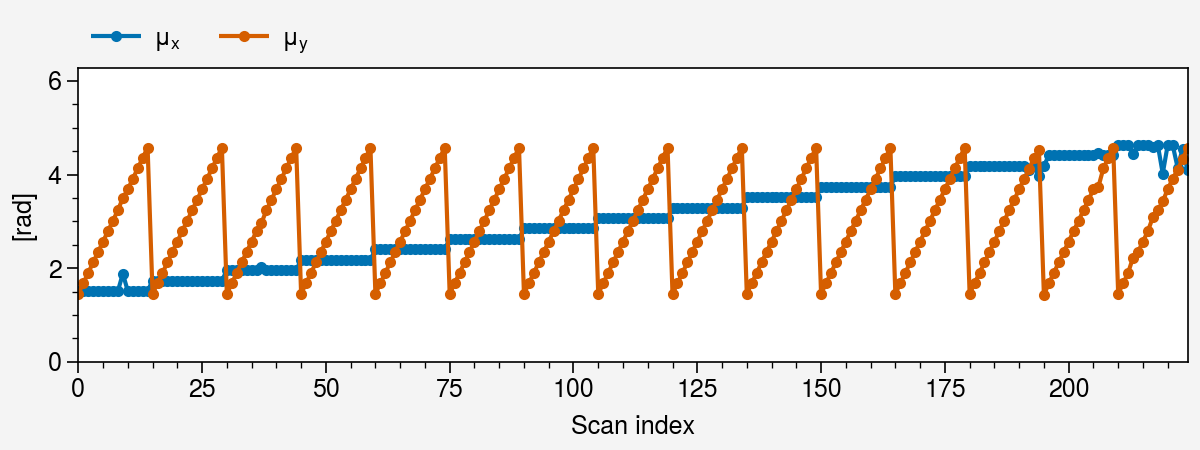

In [4]:
fig, ax = pplt.subplots(figsize=(6, 2.25))
g1 = ax.plot(phase_adv[:, 0], marker='.')
g2 = ax.plot(phase_adv[:, 1], marker='.')
ax.legend([g1, g2], labels=[r"$\mu_x$", r"$\mu_y$"], loc=(0., 1.), framealpha=0.)
ax.format(ylabel='[rad]', xlabel='Scan index', ylim=(0., 2*np.pi))
plt.savefig('_output/figures/phase_adv.png', **savefig_kws)

In [5]:
twiss_filenames = [f for f in utils.list_files('_output/data/') if 'twiss' in f]
twiss_filenames = sorted(twiss_filenames, key=lambda f: float(f.split('.')[0].split('_')[-1]))
twiss_list = [np.loadtxt(f) for f in twiss_filenames]

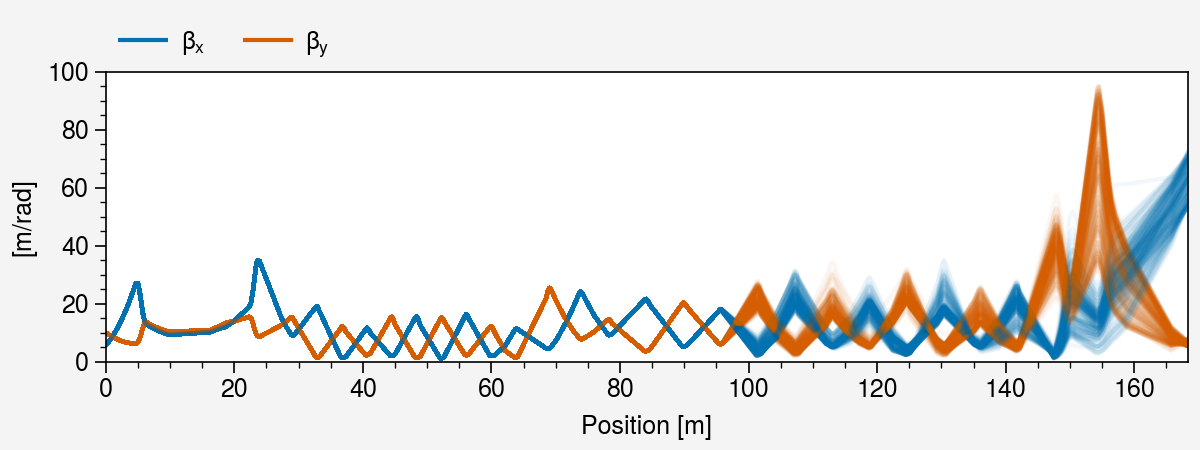

In [6]:
fig, ax = pplt.subplots(figsize=(6, 2.25))
plot_kws = dict(alpha=0.05, marker=None)
colors = myplt.DEFAULT_COLORCYCLE

for twiss in twiss_list:
    positions, mux, muy, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.plot(positions, beta_x, color=colors[0], **plot_kws)
    ax.plot(positions, beta_y, color=colors[1], **plot_kws)
ax.format(ylabel='[m/rad]', ylim=(0., 100.), xlabel='Position [m]')

lines = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
ax.legend(lines, [r"$\beta_x$", r"$\beta_y$"], loc=(0., 1.), framealpha=0.)
plt.savefig('_output/figures/beta_vs_pos.png', **savefig_kws)

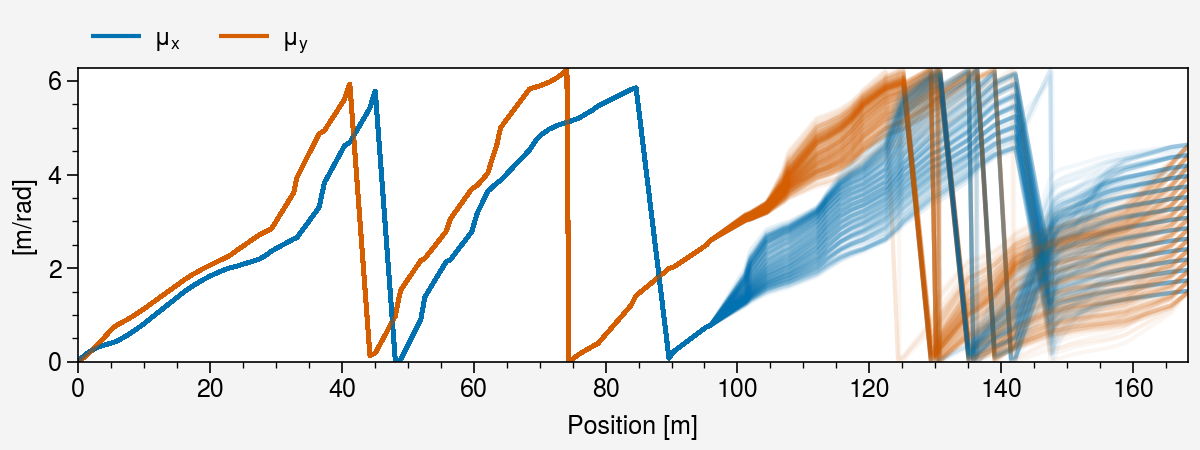

In [7]:
fig, ax = pplt.subplots(figsize=(6, 2.25))
for twiss in twiss_list:
    positions, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.plot(positions, mu_x, color=colors[0], **plot_kws)
    ax.plot(positions, mu_y, color=colors[1], **plot_kws)
ax.format(ylabel='[m/rad]', xlabel='Position [m]', ylim=(0., 2*np.pi))

lines = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
ax.legend(lines, [r"$\mu_x$", r"$\mu_y$"], loc=(0., 1.), framealpha=0.)
plt.savefig('_output/figures/phase_adv_vs_pos.png', **savefig_kws)

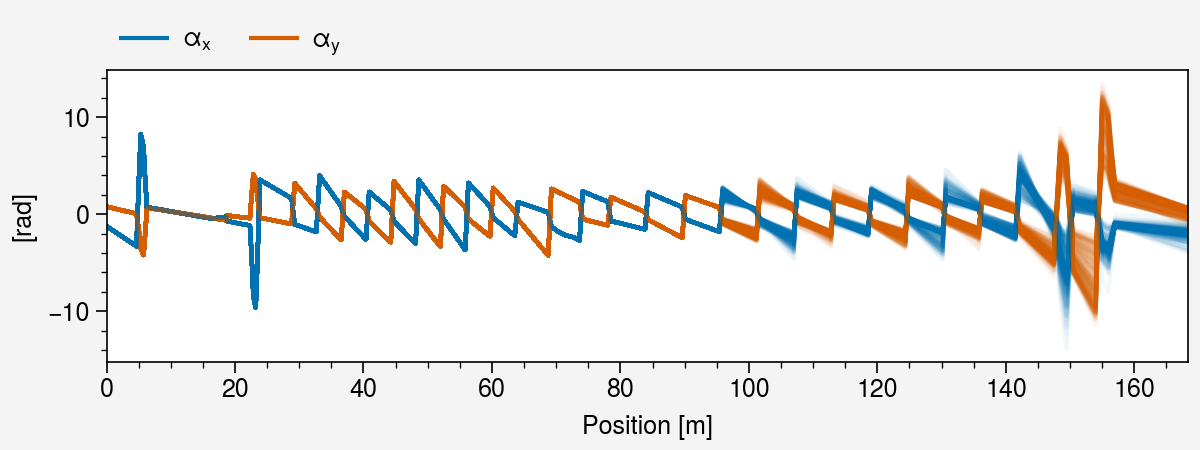

In [8]:
fig, ax = pplt.subplots(figsize=(6, 2.25))
for twiss in twiss_list:
    positions, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.plot(positions, alpha_x, color=colors[0], **plot_kws)
    ax.plot(positions, alpha_y, color=colors[1], **plot_kws)
ax.format(ylabel='[rad]', xlabel='Position [m]')

lines = [Line2D([0], [0], color=colors[0]), Line2D([0], [0], color=colors[1])]
ax.legend(lines, [r"$\alpha_x$", r"$\alpha_y$"], loc=(0., 1.), framealpha=0.)
plt.savefig('_output/figures/alpha_vs_pos.png', **savefig_kws)

In [19]:
fields = pd.read_table('_output/data/fields.dat', sep=' ')
fields.head()

,RTBT_Mag:QH18,RTBT_Mag:QV19,RTBT_Mag:QH26,RTBT_Mag:QV27,RTBT_Mag:QH28,RTBT_Mag:QV29,RTBT_Mag:QH30,Unnamed: 7
0,1.848655,-1.736721,2.552146,-1.686152,2.186375,-1.288830,0.638414,NaN
1,1.931955,-1.960868,2.942756,-1.565251,2.095127,-1.431572,0.808230,NaN
2,1.930311,-2.021289,2.759720,-1.562139,2.180995,-1.356154,0.634752,NaN
3,1.939564,-2.100738,2.650397,-1.474600,2.211221,-1.403699,0.621034,NaN
4,1.976375,-2.169989,2.894367,-1.506458,2.159226,-1.428412,0.690272,NaN


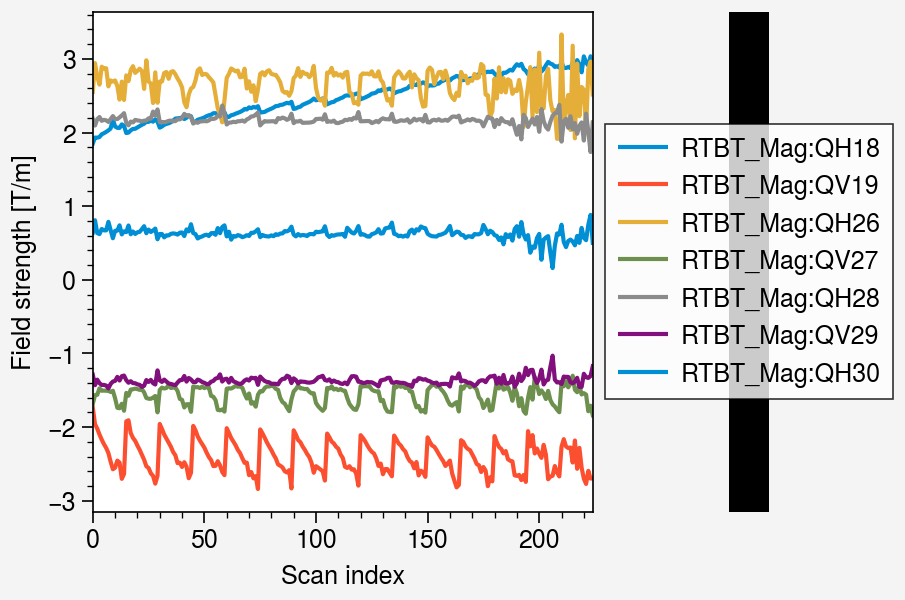

In [20]:
fig, ax = pplt.subplots()
ax.format(ylabel='Field strength [T/m]', cycle='538', xlabel='Scan index')
for col in fields.columns[:-1]:
    ax.plot(fields.loc[:, col])
ax.legend(ncols=1, loc='r')
plt.savefig('_output/figures/fields.png', **savefig_kws)